# Sign Language Recognition Based Word Prediction
## Group 10
Mohamed Ragab, Abhay Aradhya, Andri Ashfahani, Shubham Pateria

In [0]:
# import
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import time 
import os    
import copy
import math
import csv
from threading import Thread

import torch
import string
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import requests
from bs4 import BeautifulSoup
import re
import urllib3
from urllib.request import urlopen

from IPython.display import clear_output 
from IPython.core.display import Image


from Analysis_Utils import *
from CNN_Utils import *
from DataGen_Utils import *

from global_defs import *

import warnings
warnings.filterwarnings('ignore')


## BACKGROUND
<div style="text-align: justify"> Sign language is the primary mode of communication for people who are deaf and dumb. Automatic interpretation of sign language into natural language (English) words helps to bridge the communication gap between such people and the real world. Our motivation is to build a model which improves such interpretation. </div>
<br>

<div style="text-align: justify"> The core objective is to take a series of hand gestures as input and provide a corresponding word as the output. In order to train the network, the most frequently used words in real world were obtained from crawling the <a href="https://en.wikipedia.org">wikipedia</a>  webpage. Futher, the words were reconstructed in the sign language using the Sign Language MNIST dataset consisting of 34,627 grayscale images of dimension 28 × 28. </div>
<br>

<div style="text-align: justify"> In the literature deep Convolutional Neural Networks (CNNs) have been recently been used and achieved a state of the art accuracy of 99.99%. However, a simple CNN based approach is prone to noisy data. Therefore, we propose a CNN-LSTM coupled sign language interpreter to consider the context of the alphabet being predicted and thereby improve the prediction accuracy. In this project, we propose two architectures to handle the problem. </div>
<br>

<div style="text-align: justify"> Firstly, a decouple CNN and LSTM model is proposed, where the CNN and LSTM are separately trained using different datasets. The images from the MNIST dataset is used to train the CNN based image to alphabet prediction model, whereas the words from the data scapper were used to generate mis-spelled words in order to train the LSTM. During testing the individual models were linked in series such that the predicted alphabets from the CNN is considered the input to the LSTM. Secondly, a end-to-end prediction model named CLSTM was developed by integrating the CNN and LSTM architectures. CLSTM was trained and tested using the sign language words constructed using the commonly used list of words. Lastly, both the architecutes were tested using a common hold-out test dataset and their resutls were tabulated. </div>
<br>


<div style="text-align: justify"> CNN based approaches show promising accuracy for sign language recognition. However, they are invariant to the context of an alphabet within a word, and are prone to misclassification of gestures. Long Short Term Memory (LSTM) networks have been successfully used to model the sequential dynamics of text data. We propose to use LSTM as post-processing block to rectify the erroneous predictions of CNN by incorporating the context of an alphabet. </div>

## Data Acquisition and Exploration
<br>

<div style="text-align: justify"> To build a robust model to predict words from sign languages we generate two separate datasets. First, a dictionary of words is to be defined. And finally a set of hand gestures images are needed to construct the sequence of images to translate the dictonary to sign language.</div><br>




### Data Scrapper 
<br>

<div style="text-align: justify"> The commonly misspelled words in Wikipedia were used to training the dataset. A data crawling algortihm has been imlemented to crawl the  <a href="https://en.wikipedia.org/wiki/Wikipedia:Lists_of_common_misspellings">webpage</a>  and generate a list of 5284 most commonly misspelled words.  </div>
<br>

The commonly misspelled words are obtained by first, inspecting the page source of the target web page to find the corresponding tags and attirbutes, after that we read the web page into python by using **requests** library and store the output into object **web_page** object. Then parse the HTML page into a soup object(i.e.  store the object in a sensible structure) which is an object of class Beauteiful soup. Finally, we collect all the records from with the corresponding tags and attributes from the HTML and save them in a tabular data form.

In [0]:
scrap_data=[]
letters = list(string.ascii_uppercase)
for i in range(0,26): 
    A_Z=letters[0:26]
    url="https://en.wikipedia.org/wiki/Wikipedia:Lists_of_common_misspellings/"+A_Z[i]
    web_page= requests.get(url);
    # parsing the web page 
    
    soup= BeautifulSoup(web_page.text,'html.parser')
    # finding the records with corresponding tags and attirbutes of our words
    
    records=soup.findAll('span', attrs={'class':'plainlinks'})
    
    # extracting the words 
    for record in records:
        misspell=record.find('a').text[1:-1]
        correct_spell=record.find('a').text

        scrap_data.append((A_Z[i],misspell,correct_spell))
# save the output in a tabular dataframe 
df = pd.DataFrame(scrap_data, columns=['    Character', 'Misspelled Word', 'Label/Correct']) 
df.to_csv('Misspelled_correct_words_data.csv', index=False, encoding='utf-8')  

df.head()

,Character,Misspelled Word,Label/Correct
0,A,bberan,abberant
1,A,bberatio,abberation
2,A,bbrieviate,abbrieviated
3,A,bbriviate,abbriviated
4,A,bbriviatio,abbriviation


### Sign Language Images 
<br>

<div style="text-align: justify"> The Sign Language MNIST dataset consisting of 34,627 grayscale images of dimension 28 × 28 was considered to reconstruct the sequence of images to translate the dictonary to sign language. The Sign Language MNIST dataset is a multi-class problem with 24 classes of alphabets (excluding J and Z which require motion). The image dataset was split into a training dataset (27,455 images) and test dataset (7172 images). </div>

In [0]:
train_image_file = 'sign_mnist_train.csv'

test_image_file = 'sign_mnist_test.csv'

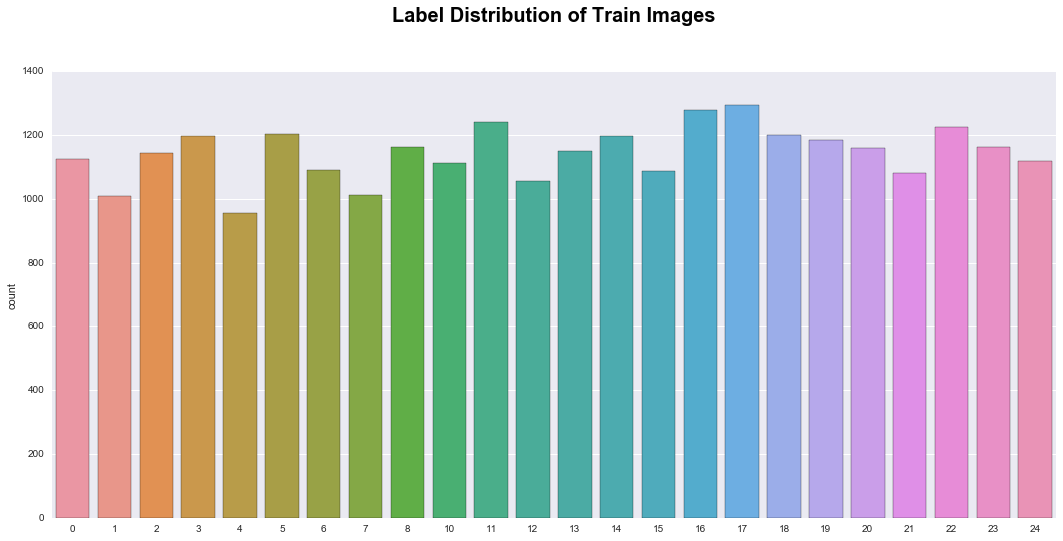

In [0]:
train = pd.read_csv(train_image_file)

train_labels = train['label'].values

plt.figure(figsize = (18,8))
plt.title('Label Distribution of Train Images', fontsize=20.0, y=1.1, color='black', fontweight='bold')
sns.countplot(x = train_labels)
plt.show()
train.drop('label', axis = 1, inplace = True)

train_images = train.values
train_images = train_images.reshape(train_images.shape[0], 28, 28)

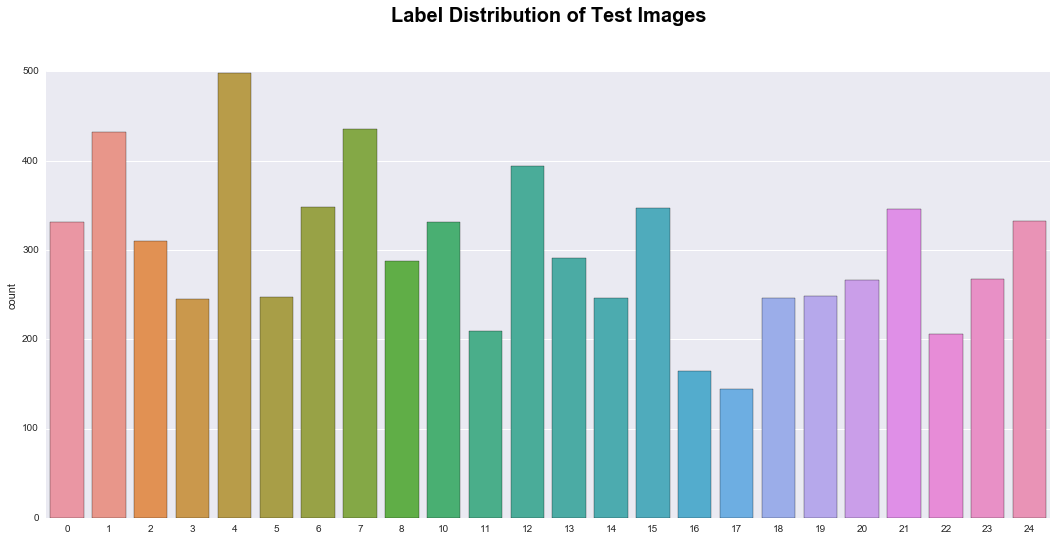

In [0]:
test = pd.read_csv(test_image_file)

test_labels = test['label'].values

plt.figure(figsize = (18,8))
plt.title('Label Distribution of Test Images', fontsize=20.0, y=1.1, color='black', fontweight='bold')
sns.countplot(x = test_labels)
plt.show()
    
test.drop('label', axis = 1, inplace = True)
    
test_images = test.values
test_images = test_images.reshape(test_images.shape[0], 28, 28)

## Visualize Images 

Collect all images...

In [0]:
training_collection = [[] for x in range(26)]

for i in range(len(train_images)):
    img = train_images[i]
    lbl = train_labels[i]
    
    training_collection[lbl].append(img)

    
testing_collection = [[] for x in range(26)]

for i in range(len(test_images)):
    img = test_images[i]
    lbl = test_labels[i]
    
    testing_collection[lbl].append(img)

In [0]:
alphas = list(string.ascii_lowercase)  ### list of alphabets

def draw_imgs(alphabet, typ):  

    l = alphas.index(alphabet)

    fig = plt.figure(figsize = (18,8))
    
    collection = []
    if typ == 'train':
        plt.suptitle('Training Images for ' + alphabet, fontsize=20.0 , color='black', fontweight='bold')
        collection = training_collection
    elif typ == 'test':
        plt.suptitle('Test Images for ' + alphabet, fontsize=20.0 , color='black', fontweight='bold')
        collection = testing_collection
    else:
        print('\nInvalid Type of Dataset!!!\n')
        return
        
        
    ims = []
    maxshow = min(len(collection[l]), 10)  #################### change the number of plotted images here

    ln = len(collection[l][:maxshow])   #### can try random sampling of indices
    plot_size = int(math.sqrt(ln))+1

    for i in range(ln):
        plt.subplot(2, 5, i+1)
        im = plt.imshow(collection[l][i], cmap='gray')
        plt.xticks([])
        plt.yticks([])

        
    return fig

def Gesture_Vis():
    fig1 = None
    fig2 = None

    while 1:

        alphabet = input("Enter the desired alphabet ('xx' to exit): ")
        alphabet = alphabet.lower()

        if alphabet == 'xx':
            clear_output()
            break

        if (alphabet not in alphas) or alphabet == 'j' or alphabet == 'z':
            print('\n Sorry! This alphabet is not in Sign Language datset.\n')
            continue

        #### !!!!: clearing doesn't work in notebook !!!!!
        if fig1 != None or fig2!=None:
            clear_output()


        if alphabet == '-1':
            break

        print('working on it....')
        fig1 = draw_imgs(alphabet, 'train')        
        plt.show()
        #fig2 = draw_imgs(alphabet, 'test')       
        #plt.show()

Enter the alphabet for which you want to visualize the hand gestures. To exit visualization, enter 'y' when exit propmpt occurs.
The input can be given as lowercase or uppercase alphabets.

Note: Labels 'j' and 'z' are not in the dataset. Hence, visualization will not work for these alphabets. 

In [0]:
thread = Thread(target = Gesture_Vis)
thread.start()
thread.join()

## Data Augmentation and PreProcessing 
<br>

<div style="text-align: justify"> Some of the words obtained from the data scrapper were found to include speacial characters, any words were removed, as the representations of the special character are not defined in the sign language interpretation. Also, words containing the alphabets "J" and "Z" were excluded from the dictionary as the representations of these alphabets can not be encapsulated in a single image frame. Further, words with less than four (4) alphabets were removed to obtain meaningful words to obtain a dictionary of 5060 words. </div>
<br>

<div style="text-align: justify"> Deep learning algorithms are data intensive learning methodologies, therefore the 5060 words in the dictionary are insufficient to accurately learn the classification. To create new data, an mis-spelling word generator was created. The data generator algorithm serves both the CNN-LSTM coupled sign language interpreter and the CLSTM algorithms. Therefore, a generic algorithm was developed that generates mis-spellings by randomly choosing an alphabet in the word to mutate. The mutation in inteself is an arbitrary process and replaces the alphabet with a random alphabet (excluding J and Z). The data generator was modelled so that the number of mutations for a given word can be defined by the user, however, the maximum number of mutations is limited by half of the word length. Using the mis-spelling word generator 100 mis-spelled words (mutations) were generated for each word in the dictionary resulting a dataset of 500,000 mis-spelled words.</div>
 <br>
<div style="text-align: justify"> Althogh the number of mis-spelled words play an important role in training the LSTM model to correct plausible mis-classifications by the CNN, but also it is important to prevent any errors in the LSTM when presented a true word. Hence, supplemented the mis-spelled words with 20% of true words. Therefore for every true word obtained from the data srapper, the dictionary contains 80 mis-spellings generated by the mis-spelling word generator and 20 repetitions of the true word.</div>
 <br>
<div style="text-align: justify"> Further, in order to train the CLSTM classifier 100 different sign language represenatations of each word from the list of true words obtained using the data scrapper were obtained to train the network. Importantly for training the network only images from the Sign Language MNIST dataset was used. Similarly the images from the test Sign Language MNIST dataset was used to generate the sign language representations of the word.</div>
 <br>
<div style="text-align: justify"> Lastly, from the augmented dataset 10% of the data was separated to form a hold-out testing dataset. Therfore, 400,000 words from the augmented dataset was used to train the network and 100,000 words from the dataset was used to test the preformance and robustness of the algorithm.</div>

## Models
<div style="text-align: justify"> In this project, there are 5 models proposed to obtain the goal. Those are basic CNN, CNN + LSTM, CNN + Sequence-to-sequence model, end-to-end convolutional LSTM (CLSTM), and CLSTM + Sequence-to-sequence model. The following passages provides detailed explanation of each of those network structure.</div>

### Model 1: Basic CNN

<div style="text-align: justify"> In this project, the designed CNN consist of a 5 layer network structure where there are 3 convolutional layers and 2 fully connected layers. The input dimension is defined in the first layer. That is, the dimension of a 28-by-28 pixel image. The intermediate convolutional layers are interspersed by ReLU and max-pooling layers. A rectangular grid connection is employed in convolutional layer where each connection share the same weights. A ReLU activation function is also installed between 2 fully connected layers. The outputs of convolutional layer are sub-sampled by the 2-by-2 max-pooling layer to reduce its dimension to 64-by-4-by-4 matrix. After that, it is converted to a 1024-by-1 vector and the first fully connected layer maps that vector to 128-by-1 vector. Finally, the last fully connected layer functions to classify 26 alphabets by mapping the 128-by-1 vector to 26-by-1 vector. The network architecture can be seen in the following figure and the class definition of CNN is outlined in the following cell. This architecture is adapted from <a href="https://www.kaggle.com/ranjeetjain3/deep-learning-using-sign-langugage">kaggle</a>.</div>
<img src="CNN_Solo.JPEG" alt="Drawing" style="width: 700px;"/>

#### Class Definition 

In [0]:
class convnet(nn.Module):

    def __init__(self, classes, dropout1):

        super(convnet, self).__init__()
        
        # CL1:   28 x 28  -->    64 x 28 x 28 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        self.conv2 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        self.conv3 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        self.to_pad = 1
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        self.pool3 = nn.MaxPool2d(2,2, padding=self.to_pad)
        
        if self.to_pad:
            # LL1:   64 x 4 x 4 = 1024 -->  128 
            self.linear1 = nn.Linear(1024, 128)
        else:
            # LL1:   64 x 3 x 3 = 576 -->  128 
            self.linear1 = nn.Linear(576, 128)
        
        self.dropout1 = nn.Dropout(dropout1) 
        
        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, classes)


    def forward(self, x):

        # CL1:   28 x 28  -->    64 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        x = self.pool2(x)

        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        x = self.conv3(x)
        x = F.relu(x)
        
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        x = self.pool3(x)
        
        
        # LL1 
        if self.to_pad: x = x.view(-1, 1024)   ### reshape
        else: x = x.view(-1, 576)
        x = self.linear1(x)
        x = F.relu(x)
        
        
        # Droput
        x = self.dropout1(x)
        
        # LL2:   128  -->  classes
        x = self.linear2(x)
    
        return x


### Model 2: CNN + LSTM
<div style="text-align: justify"> The capability to exploit strong spatially local correlation of images enables CNN classify images with ease. The goal of this project, however, is not only to classify image but also to predict a word based on a sequence of hand gesture images which can be regarded as a spatiotemporal sequence prediction problem. It is worth mentioning that CNN is unable to handle temporal dependancy as it does not have recurrent connection. This problem can be circumvented by stacking a LSTM network on top of the CNN. Note that in the realm of deep neural network, LSTM performs better than CNN while modelling temporal dependency for input sequences.</div>
<br>

<div style="text-align: justify"> In this project, the LSTM is preceded by an embedding module and is followed by a linear layer, and an output layer. The input of embedding layer is a sequence of character index which is the output sequence of CNN. The index varies from 1 to 26 representing the alphabets. This index is the input of character embedding layer. This layer possesses 26-by-256 dimension matrix $U$ where the number 256 indicates the hidden size of LSTM layer. By this approach, every character is represented by 1-row vector ($g_t$) of matrix $U$. After that, $g_t$ is processed by LSTM layer and it produces 256-by-1 vector which is then mapped to 26-by-1 vector by linear layer. Finally, the output layer performs softmax operation to obtain the multiclass probability where the predicted characters is the one possessing the highest probability. The network parameters are adjusted using SGD method with cross entropy loss criteria.  In this project, we tried 3 experiments by varying LSTM configuration those are, unidirectional LSTM, bidirectional LSTM, and bidirectional LSTM with dropout in linear layer. The configuration possessing the best performance is connected to the CNN to solve the word prediction problem. Note that, CNN and LSTM parameters are optimized based on different loss function. The architecture of LSTM is depicted in the following figure and its class definition is outlined in the next cell. </div>
<img src="lstm.jpg" alt="Drawing" style="width: 800px;"/>

#### Class Definition 

In [0]:
class Recurrent_Layer(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Recurrent_Layer, self).__init__()
        self.dropout = nn.Dropout(0.02) # this can be removed while without dropout configuration
        self.layer1 = nn.Embedding (vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, vocab_size) # if bidirectional=True then hidden size multiplied by 2

    def forward(self, x, h_init,c_init):
        x = self.dropout(x) # this can be removed while without dropout configuration
        g_seq = self.layer1(x)
        h_seq, (h_final, c_final) = self.lstm(g_seq, (h_init,c_init))
        score_seq = self.fc(h_seq)
        
        return score_seq,  h_final , c_final

### Model 3: CNN + Squence-to-sequence Model
The **squence-to-sequence** network is employed in this project. In this sequence to sequence network, we have two main LSTM networks, one of them is the **encoder** take the missplled outputs of CNN baseleine and try to encode the context of the whole word into one hidden vector with a fixed size and pass to the other part. The other part is the **decoder** which take this context vector and as its initial hidden state coupled with an intial input like "SOW" to predict the next character of the word. The detailed working process is as follows, first we try get the vector representation for every character by employing a learnabel **character embedding** layer, which in turn forwoard the vector representation of every character to the lstm cells.Each cell in LSTM layer will take the hidden state from the prevoius lstm cell coupled with the current input to produce the output, until we reach the last hidden state which have the context of the whole input word, this can be considered as encoding part. After that the decoder part will cosider the encoder's last hidden state as its inital hidden and try to decode this to genertate the correctly spelled words as shown in figure below.
<img src="seq2seq.jpeg" alt="Drawing" style="width: 800px;"/>

#### Class Definition 

In [0]:
# Encoder Architecture 
class EncoderLSTM(nn.Module):
    def __init__(self,input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding=nn.Embedding(input_size, hidden_size)
#         self.dropout=nn.Dropout(0.5)
        self.lstm=nn.LSTM(hidden_size, hidden_size )
    
    def forward(self, x, h_init, c_init):
        
        g_seq=self.embedding(x)
#         g_seq= self.dropout(g_seq)
        output, (h_final,c_final)=self.lstm(g_seq, (h_init, c_init))
        return output, h_final, c_final

In [0]:
# Decoder Architecture 
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm=nn.LSTM(hidden_size, hidden_size)
        self.out=nn.Linear(hidden_size, output_size)

    def forward(self, x, h_init, c_init):
        output=self.embedding(x)
        output, (h_final, c_final)=self.lstm(output, (h_init, c_init))
        output=self.out(output) # do we need output[0] ?
        #output= self.softmax(output)
        return output, h_final, c_final

### Model 4: End-to-End Convolutional LSTM (CLSTM)
<div style="text-align: justify"> In the realm of deep learning, a reasonable end-to-end model and sufficient data for training helps the user to get closer to the problem solution. It also worth mentioning that the word prediction problem satisfies the data requirement because it is easy to generate a lot of words. Because of this reason, this project realizes end-to-end convolutional LSTM (CLSTM) to predict the word from a sequence of images. CNN should be able to handle the spatio dynamic while the temporal dynamic is circumvented by LSTM. Unlike our previous models, where the network parameters are optimized based on different objective function, CLSTM parameters are adjusted using loss from top layer. The following figure depicts the CLSTM network structure.</div>
<img src="clstm.jpeg" alt="Drawing" style="width: 700px;"/>

#### Class Definition 

In [0]:
class CLSTM(nn.Module):
    
    def _init_(self, h_dim, classes, bi_dir=False):
        
        super(CLSTM, self)._init_()

        self.hidden_dim = h_dim
        
        # CL1:   28 x 28  -->    64 x 28 x 28 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        self.conv2 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        self.conv3 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        self.to_pad = 0
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        self.pool3 = nn.MaxPool2d(2,2, padding=self.to_pad)
        
        if self.to_pad:
            # LL1:   64 x 4 x 4 = 1024 -->  128 
            self.linear1 = nn.Linear(1024, 128)
        else:
            # LL1:   64 x 3 x 3 = 576 -->  128 
            self.linear1 = nn.Linear(576, 128)
        
        
        self.dropout1 = nn.Dropout(0.7)
        
        self.dropout2 = nn.Dropout(0.7)
        
        # LSTM
        self.lstm_in_dim = 128
        self.lstm = nn.LSTM(self.lstm_in_dim, self.hidden_dim, bidirectional=bi_dir)

        # linear
        self.hidden2label1 = nn.Linear( self.hidden_dim*(1+int(bi_dir)), classes )
        
        

    def forward(self, x, h_init, c_init):
        
        x = self.conv1(x)
        x = F.relu(x)

        x = self.pool1(x)
         
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool2(x)
 
        x = self.conv3(x)
        x = F.relu(x)
        
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        x = self.pool3(x)
        
        if self.to_pad: x = x.view(-1, 1024)   ### reshape
        else: x = x.view(-1, 576)
        x = self.linear1(x)
        x = F.relu(x)     
        
        # Droput
        x = self.dropout1(x)

        cnn_x = F.relu(x) 
        
        # LSTM
        g_seq = cnn_x.unsqueeze(dim=1)
        lstm_out, (h_final, c_final) = self.lstm(g_seq, (h_init, c_init))
        
        # Droput
        lstm_out = self.dropout2(lstm_out)
        
        # linear
        cnn_lstm_out = self.hidden2label1(lstm_out)  ###activtions are implicit

        # output
        scores = cnn_lstm_out

        return scores, h_final, c_final

### Model 5: CLSTM + Squence-to-sequence Model
<div style="text-align: justify"> In order to obtain further improvement, the pretrained squence-to-sequence model is stacked on top of pretrained CLSTM. It functions as post-processing module of CLSTM. This model provides a general framework for sequence-to-sequence learning problems by training temporally concatenated LSTM that is, the input sequence and the output sequence. </div>

## Training Procedures for Different Models

### Training of CNN

<div style="text-align: justify"> The baseline CNN is trained on the Sign Language images. Since each image corresponds to a single alphabet label, the loss calculated here is at the alphabet (or character) level. This is different from the word-level loss used in other parts of the report. Since the baseline CNN is non-recurrent, it needs to be trained on alphabet-level loss. 
Same applies to percentage error, which is the total percentage of images recognized as Wrong alphabets. </div>

In [0]:
model_name = 'Cnet_Kaggle'

#### Hyperparameters
We observed the fastest rate of training convergence for this network with learning rate of 0.001. This value is divided by 1.5 after every 10th epoch of training. 

In [0]:
my_lr = 0.001 
epochs = 50
batch_size = 128         
CNNutils = CNN_Utils(my_lr, batch_size, epochs)

#### Cross Validation (CV)

The check the performance of the network on samples from training set, the data is randomly split into 90% training and 10% 
validation portions in 10 iterations of CV.

The record of performance is shown below.

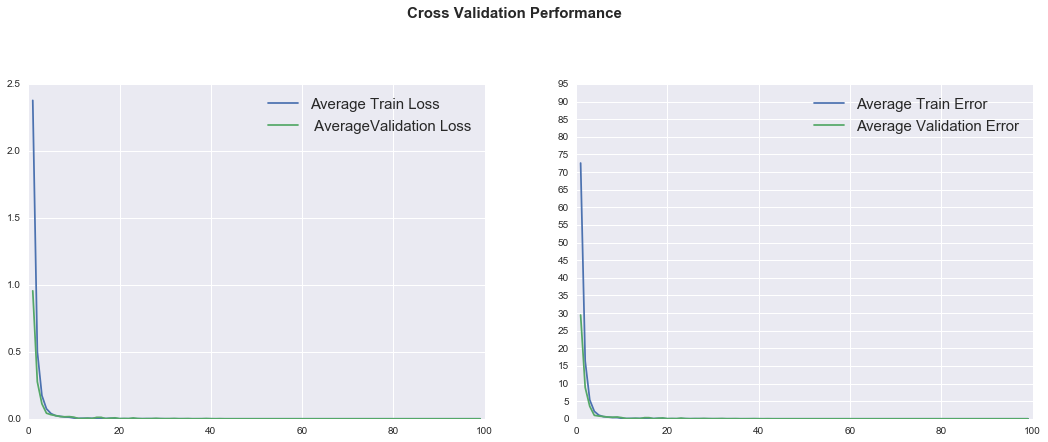

In [0]:
hCV = torch.load(model_name + '_CV_history.pt')
train_history_over_CV = hCV['train_history']
val_history_over_CV = hCV['test_history']
CNNutils.plot_CV_history(copy.deepcopy(train_history_over_CV), copy.deepcopy(val_history_over_CV))

The model seems to be performing quite well, given the low average validation error. However, this may also mean that 
the entire training data comes from a very closely distributed population. There is no guarantee of test data coming from same distribution, as we will see in the next section.

#### Full Training

Here, we train the CNN on entire training dataset while simultaneuosly evaluating on the actual test data. 

The record of performance is shown below.

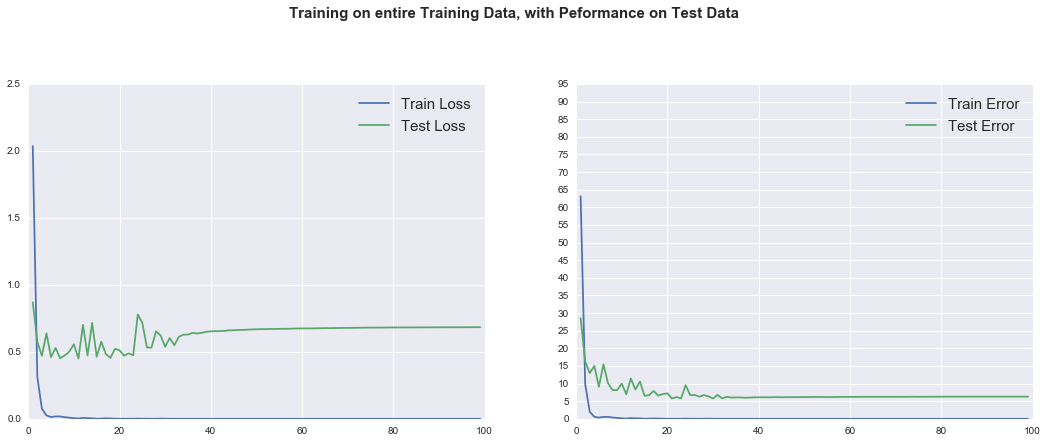

In [0]:
hFull = torch.load(model_name + '_full_history.pt')
train_history = hFull['train_history']
test_history = hFull['test_history']
CNNutils.plot_FullTrain_history(train_history, test_history)

The test performance of CNN is worse than that on Cross-Validation data. Hence, it can be inferred that test images have been sampled from a population outside the training set.

### Training of LSTM
<div style="text-align: justify"> The training process of LSTM is started by using simple LSTM model, that is unidirectional LSTM. The learning rate is set to be decaying, that is started by 0.05 and is divided by 1.1 every 10 epoch. After 204 epoch, it only achieves 5% testing accuracy and 85% training accuracy. This is because to observe the misspelled word it is requred the whole context of the word. Unidirectional LSTM, however, cannot observe the whole context as it observes a word from one direction. Because of this reason, bidirectional LSTM is utilized to improve the result. By applying the same setting, it is capable of delivering almost 84% in around 200 epoch while the training error is almost 100%. From this result, it can be observed that the network is overfitting. It can be avoided by adding dropout in the training phase. The ammount of dropout is 0.2. The result is that the testing accuracy increases up to 90% while the training accuracy is 99%. Referring to the plot of loss below, it is decided to stop the training phase because there is no significant decrease in loss. All the results are reported in the following table. After that, this model is stacked to the output of CNN layer. </div>

| Model | Train Accuracy | Test Accuracy | Train Loss | Test Loss |
| --- | --- | --- | --- | --- |
| Unidirectional LSTM | 85.29% | 5.07% | 0.067 | 0.985 |
| Bidirectional LSTM | 99.56% | 83.98% | 0.002 | 0.12 |
| Bidirectional LSTM with dropout | 99.12% | 90% | 0.0045 | 0.07 |

In [0]:
# parameter of bidirectional LSTM with dropout
hidden_size=256
vocab_size =26
my_lr=0.05

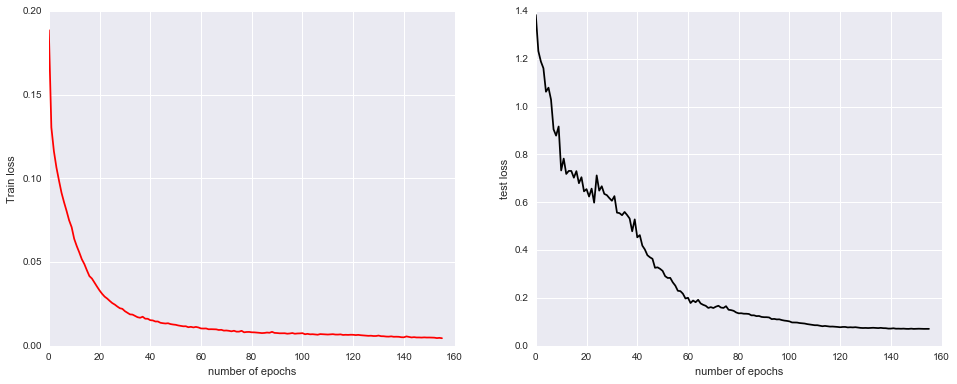

In [0]:
import torch
all_parameters= torch.load("lstm_single_char_50_mutation_bid_drop_02 (1).pt", map_location='cpu')
from seq2seq_utils import plot_loss
from seq2seq_utils import pie_plot_lstm

plot_loss(all_parameters)

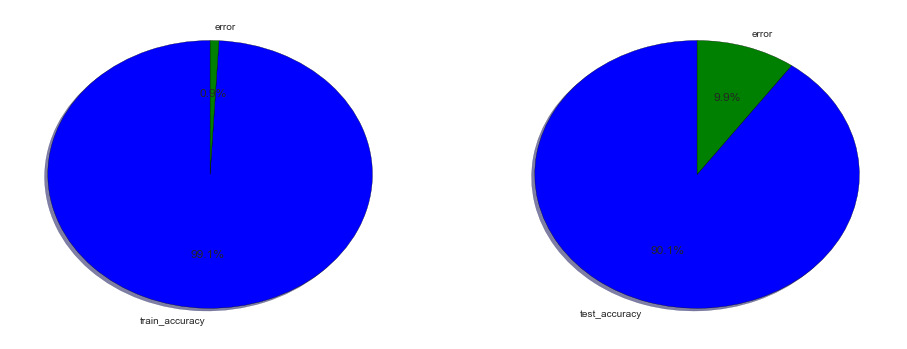

In [0]:
pie_plot_lstm(all_parameters)

Training and testing accuracy of bidirectional LSTM with dropout.
## Training of Sequence-to-sequence Model

#### Training Procedure  


In order to train our model we started by passing the input character to the embedding layer which in turn pass it to LSTM layer, which in turn wil encoder the whole input word in the last hidden state and send it to the decoder. Decoder training has two diffrent phases one phase is by forcing the input of the decoder to be to the target labels, instead of the decoder gussing as shown in figure(2). This is called **Teacher Forcing** which help in increasing the convergence speed, however it exhibit some instabliblity. So, we will  randomly use teacher forcing by some ratio  in order to improve the converegence and keep stablitiy.The two phases are shown the folllowing figures.

<img src="TeacherForcing.jpeg" alt="Drawing" style="width: 700px;"/>

In order to tune our **hyberparameterts** we started to train our  model on small subset of the data, and try to overfit this small subset of data, at this point we ensured that we have enough capacity. In our case, we tried this and ended with these parameters,  **256 hidden size** of the lstm cell, we also used **Stochastic Gradient Descent(SGD)** which is the optimal for lstm and reached to optimal, we also we ended up with a good **learning rate strategy** which start by learning rate=**0.04** and reduce it by **1.1** every **10** epochs.With this strategyy it took us 72 epochs to end up with training accuracy of **99%** and testing accuracy **96.1%**.


In [0]:
# hyperarameters
hidden_size=256
vocab_size=26    
my_lr=0.04
Teacher_forcing_ratio=0.4

We start to train our model using theses arameters and here is a summary of accuracy and losses for both training and testing.


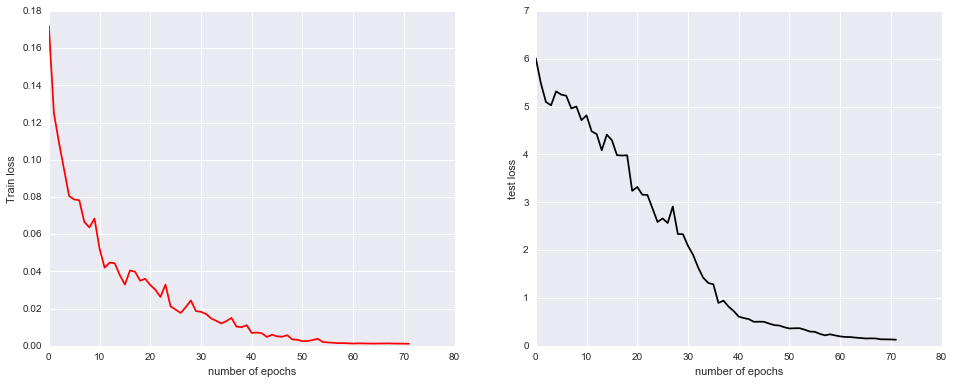

In [0]:
import torch
all_parameters= torch.load("seq_seq_model_sinlgle_char_50_mutation_200.pt", map_location='cpu')
from seq2seq_utils import plot_loss
from seq2seq_utils import pie_plot_lstm

plot_loss(all_parameters)

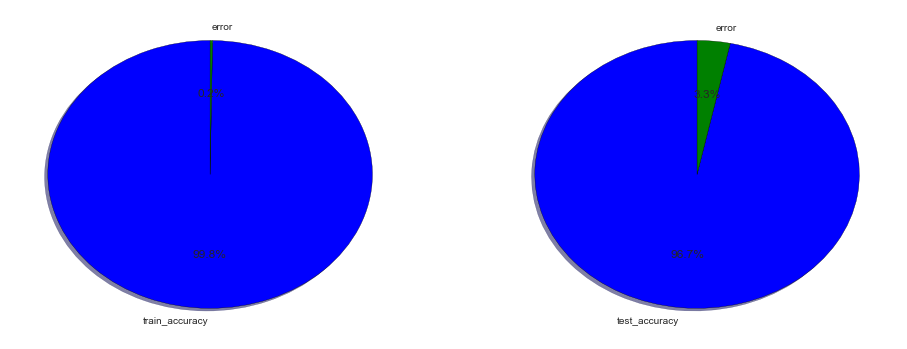

In [0]:
pie_plot_lstm(all_parameters)

## Training of CLSTM
<div style="text-align: justify"> The training of the CLSTM is carried out by passing the image sequence representing the textual word in sign language to the convolution layer. The vector output from the CNN fully connected layer is considered as the input to the bi-directional LSTM layer of hidden size 256. The hidden layer is connected to the output layer of dimension 26 for each cell, which represents the class activation of each alphabet.</div><br>
    
<div style="text-align: justify"> The CLSTM was trained using Stochastic Gradient Descent(SGD) approach over 60 iterations with a learning rate of 0.04, which was reduced by a factor of 1.2 every 10 epocs.  With the above architecture the CLSTM achieved a maximum classification accuracy of 79% over the training dataset. However, a training accuracy of 99.5% was achieved. The results indicate clear overfitting, therefore we regularized the learning by introducing dropout of 0.7 in both the fully connected layers of the CNN and LSTM. The new learning stratergy ensured that the model does not overfit the training data and achieves a 97% accuracy on the testing dataset.</div><br>

# Evaluation and Comparisons of Models

### Load All Models

In [0]:
#############################  Conv Net #######################################
Cnet = torch.load('Cnet_Kaggle.pth', map_location=map_loc).eval()



#############################  LSTM #######################################
lstm = torch.load('LSTM_w_do.pth', map_location=map_loc).eval()



############################## Seq2Seq ####################################
seq2seq = torch.load('seq_seq_model_sinlgle_char_50_mutation_200.pt', map_location=map_loc)

encoder_dict = seq2seq['encoder_model']
encoder = EncoderLSTM(vocab_size,hidden_size)
encoder.load_state_dict(encoder_dict)
encoder = encoder.eval()

decoder_dict = seq2seq['decoder_model']
decoder = DecoderLSTM(hidden_size, vocab_size)
decoder.load_state_dict(decoder_dict)
decoder = decoder.eval()



#############################  CLSTM #######################################
clstm = torch.load('CLSTM.pth', map_location=map_loc).eval()


### Load Test Data

The test data is generated by taking 200 true (or correct) words and fetching 100 image-sequences for each word. Each sequence consists of images randomly sampled from the test set of Sign Language MNIST. Sample sequences are shown below.

In [0]:
listOfwords = csv2data('Misspelled_correct_words_data.csv')

trainImages = csv2images('sign_mnist_train.csv')

testImages = csv2images('sign_mnist_test.csv')

### Arguments
# First three are data 
# 4th is the number of image-sequences per word
# 5th is 
# 6th is the fraction of test data in the generated data; cannot be = 1.0
# 7th is the ratio of true words to misspelled words, if 1.0: all words are true
word_to_train_imgs, word_to_test_imgs = GenSplitData(listOfwords, trainImages, testImages, 102, 0, 0.99, 1.0)

torch.save(word_to_train_imgs, 'FinalEval_trainWordstrainImages.pt')
torch.save(word_to_test_imgs, 'FinalEval_testWordstestImages.pt')

In [0]:
print("loading data...")

test_images = csv2images('sign_mnist_test.csv')
testWordstestImages = torch.load('FinalEval_testWordstestImages.pt')   #### this data should be common for all evaluations

num_of_img_sequences_per_word = 100 ### approximately

test_data_size = 200 * num_of_img_sequences_per_word

data, labels = get_data(testWordstestImages, test_images, test_data_size)
print("done")

print("number of data sample: ", len(data), '\n')

get_unique_words(labels, test_data_size)   ##### there are multiple image sequences per word, 
                                            #### let's see how many unique words we have

loading data...
done
number of data sample:  20000 

No. of Unique Words:  199 



Let's check various sequences for the first word

abberant


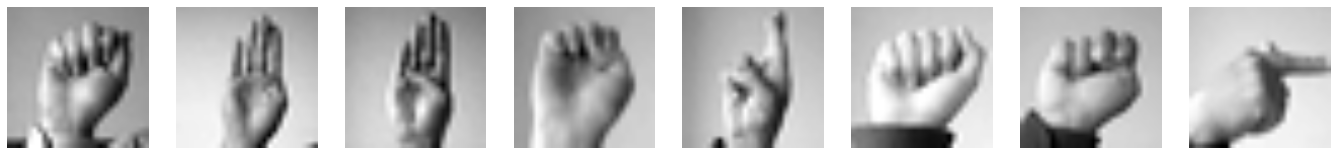

abberant


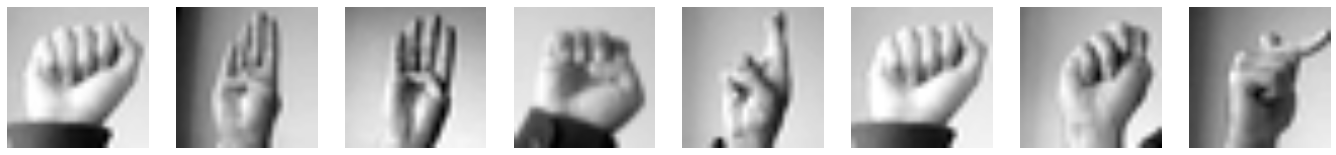

abberant


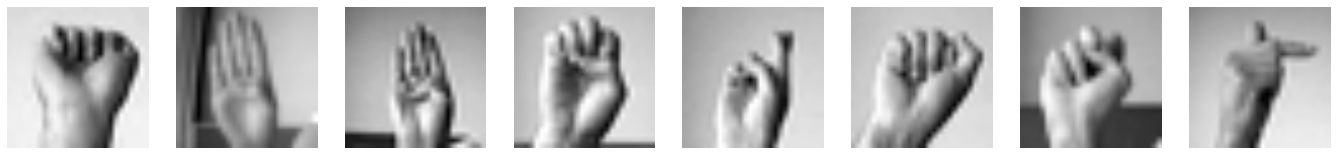

In [0]:
indices = list(range(3))

for idx in indices:
    print(testWordstestImages[idx][0])

    fig = plt.figure(figsize = (60,50))
    for j in range(len(data[idx])):
        plt.subplot(1, 20, j+1)
        im = plt.imshow(data[idx][j], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Evaluation and Comparison

Now, we use the test data obtained above as input to various models and check their performances...

In [0]:
mdl_cnt = 5
model_names = ['' for x in range(mdl_cnt)]
pred_errors = [0 for x in range(mdl_cnt)]
pred_mismatches = [[] for x in range(mdl_cnt)]
postproc_stats = [[] for x in range(mdl_cnt)]

### Baseline CNN

The baseline for performance of all models is set by a Convolutional Network without any property of recurrence. For this model, an input sequence is fed image-by-image into the trained CNN and the output alphabets are joined together into a string.

In [0]:
mdl = 0
CNN_spellings,  mismatch_cnt, err = BasicCNN_evaluation(data, labels, Cnet)

model_names[mdl] = 'CNN Solo'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = []

### LSTM Post-Processing over CNN

In [0]:
mdl = 1
LSTMoverCNN_spellings,  mismatch_cnt, err, in_out_stats = LSTM_PostProc_evaluation(CNN_spellings, labels, lstm)

model_names[mdl] = 'LSTM Post-proc over CNN'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

###  Sequence-to-Sequence Post-Processing over CNN

In [0]:
mdl = 2
Seq2SeqOverCNN_spellings, mismatch_cnt, err, in_out_stats = Seq2Seq_PostProc_evaluation(CNN_spellings, labels, 
                                                                                                       encoder, decoder)

model_names[mdl] = 'Seq2Seq Post-proc over CNN'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

### CLSTM

In [0]:
mdl = 3
CLSTM_spellings,  mismatch_cnt, err = CLSTM_evaluation(data, labels, clstm)

model_names[mdl] = 'End-to-End CLSTM'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = []

### Sequence-to-Sequence Post-Processing over CLSTM  

In [0]:
mdl = 4
Seq2SeqOverCLSTM_spellings,mismatch_cnt,err,in_out_stats = Seq2Seq_PostProc_evaluation(CLSTM_spellings, labels, encoder, decoder)

model_names[mdl] = 'Seq2Seq Post-proc over CLSTM'
pred_errors[mdl] = err
pred_mismatches[mdl] = mismatch_cnt
postproc_stats[mdl] = in_out_stats

## Accuracy
This measure is based on word-level prediction accuracy. If the predicted word matches the target word, it is treated as 1 positive instance of prediction. If the predicted word does not match target word by one or more alphabets, it is treated as 1 instance of negative prediction. In the plots below, we show the percentages of correct and incorrect predictions for various models.

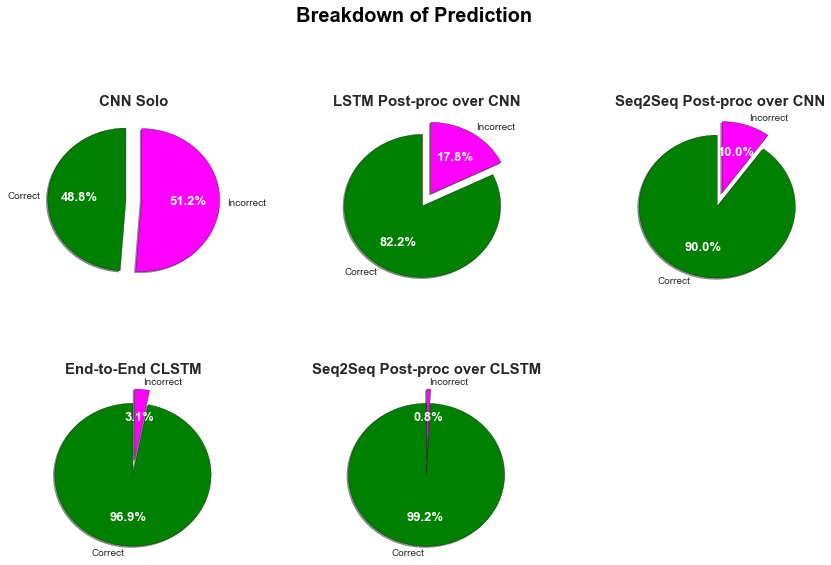

In [0]:
plot_prediction_pie(pred_errors, model_names)

For the following discussion, we interpret the LSTM and Seq2Seq models as post-processing blocks which can be applied on any Gesture image recognition model. For gesture recognition, baseline CNN shows worst performance which is expected because this model is trained only on aplphabet-level loss and has no property of recurrent connections. On the other hand, CLSTM connects the final FC layer of CNN to a bi-directional LSTM. The training is end-to-end such that CNN is learned in context of a sequence of images (gesture alphabets). This strategy clearly shows great improvment in word-level accuracy.

Among post-processing blocks, Seq2Seq shows relatively better performance than LSTM over both CNN and CLSTM. To understand where the gain comes from, let's analyze the exact effect of post-processing on the outputs of CNN and CLSTM.

## Effect of Post-processing on the Outputs of CNN
The LSTM and Sequence-to-Sequence models essentially perform a text correcting post-processing over the outputs of gesture recognition models. Here, we will analyze the performance of post-processing with respect to the intermediate inputs which are the ouputs from CNN. In the next section, we will do the same analysis for ouputs of CLSTM as inputs to post- processor.

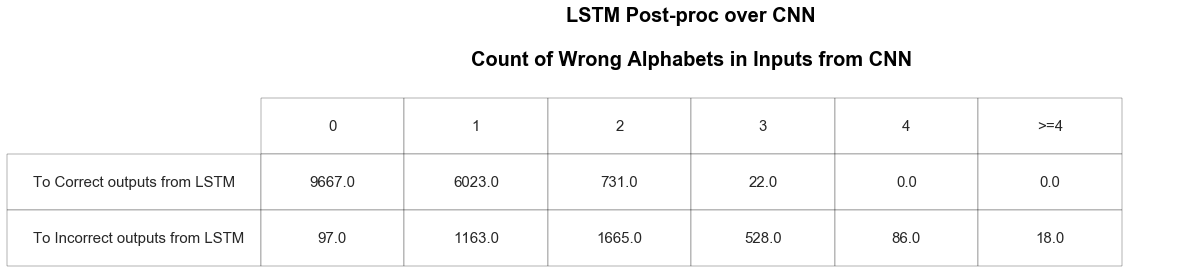

In [0]:
plot_post_processor_stats(postproc_stats[1], model_name=model_names[1])

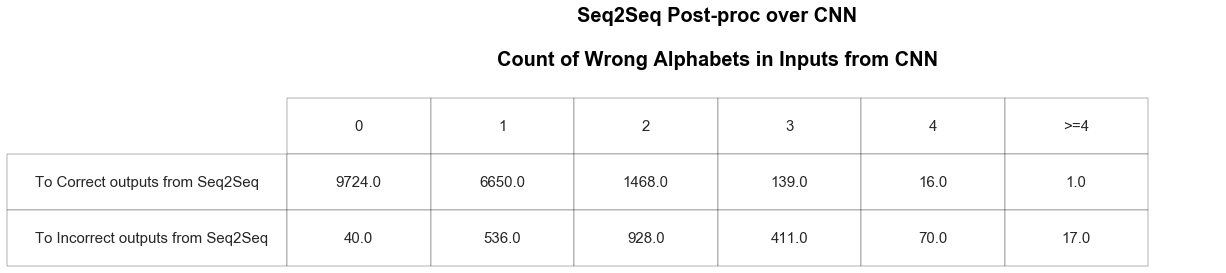

In [0]:
plot_post_processor_stats(postproc_stats[2], model_name=model_names[2])

One key observation here is that the Seq2Seq model is capable of correcting more inputs with 2 or more wrong alphabets, as compared to simple LSTM.

It's worthwhile to note here that both LSTM and Seq2Seq models are trained on words with single alphabet mistake. Yet,
Seq2Seq seems to generalize better to words with multiple aphabets mistakes.

## Effect of Post-processing on the Outputs of CLSTM

This is simply a cherry-on-the-top analysis!

Although CLSTM works quite well as Gesture Recognizer in terms of accuracy, the LSTM and Seq2Seq models can still be applied as post-processors due to being decoupled from gesture recognizer model.

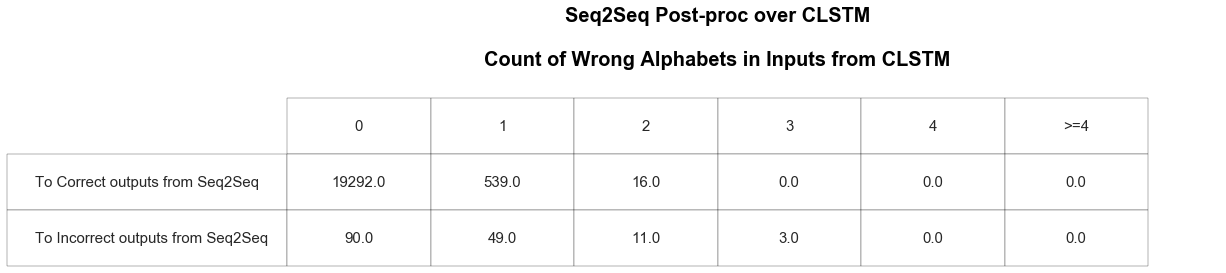

In [0]:
plot_post_processor_stats(postproc_stats[4], model_name=model_names[4])

## Mismatch between Predicted Word and True Word
Absolute accuracy shows the proportion of correct predictions, it does not provide a measure for the distance of a predicted word from true word. This may be interest to a human user in practical scenarios. Assuming that it would be easier for a user to correct a misspelled word with 1 or 2 wrong alphabets as compared to a misspelled word with more wrong aplhabets, we can define a performance measure as the distribution and average of the count of alphabet mistakes. The performances are shown below.

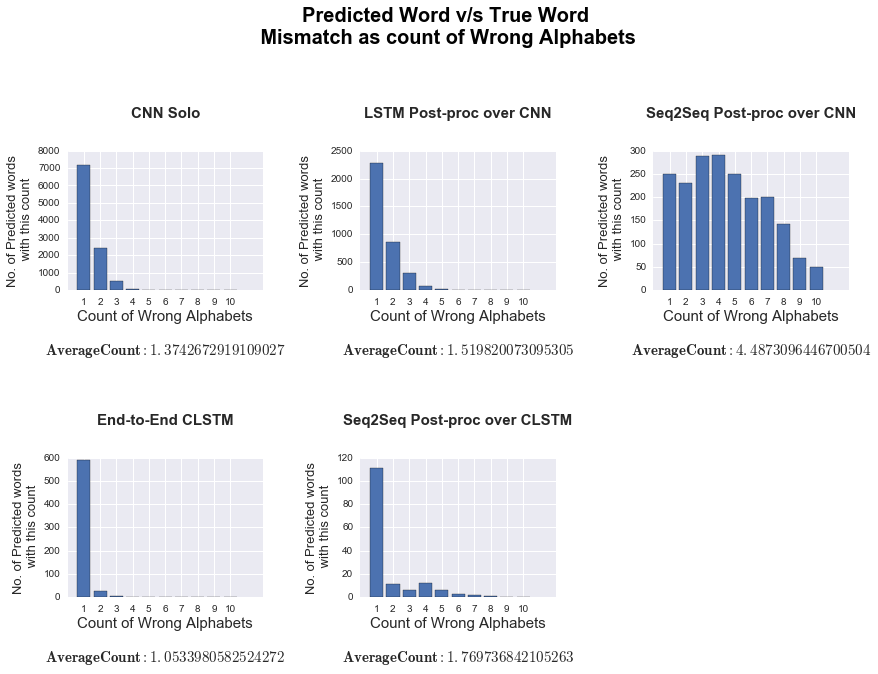

In [0]:
plot_word_mismatch(pred_mismatches, model_names)

Although Sequence-to-Sequence word corrector model enhances overall accuracy significantly, it also produces incorrect words with more wrong alphabets. This may increase the difference between true word and predicted word perceived by a user oblivious to workings of the predictor model. In simple terms, it may be easier for a user to faithfuly edit (into true word) an incorrect prediction with 1 wrong alphabet than an incorrect prediction with, say, 6 wrong aplhabets.

## Distortion Test

Let's make this analysis more interesting! We are dealing with only static images for this project. However, if we were to imagine that the input sequences of gestures came from a video or live demonstration, which is more practical, it is quite likely that some distorted images may be sampled due to continuous motion.

Here, we define a function that can perform SHEARING operation on 1 or more images from a chosen sequence.

The sequence index is given as first argument and the desired number of distortions as second argumnet.

The distortions are applied on random positions in a sequence.

In [0]:
def run(dat, temp_label):

    CNN_spellings,  mismatch_cnt, err = BasicCNN_evaluation(dat, temp_label, Cnet)

    pred = ''.join([alphas[x] for x in CNN_spellings[0]])
    print('\nCNN output\t: ', pred)

    LSTMoverCNN_spellings,  mismatch_cnt, err, in_out_stats = LSTM_PostProc_evaluation(CNN_spellings, labels, lstm)

    pred = ''.join([alphas[x] for x in LSTMoverCNN_spellings[0]])
    print('\nLSTM over CNN output\t: ', pred)

    Seq2SeqOverCNN_spellings, mismatch_cnt, err, in_out_stats = Seq2Seq_PostProc_evaluation(CNN_spellings, temp_label, 
                                                                                                                   encoder, decoder)

    pred = ''.join([alphas[x] for x in Seq2SeqOverCNN_spellings[0]])
    print('\nSeq2Seq over CNN output\t: ', pred)



    CLSTM_spellings,  mismatch_cnt, err = CLSTM_evaluation(dat, temp_label, clstm)

    pred = ''.join([alphas[x] for x in CLSTM_spellings[0]])
    print('\n\nCLSTM output: ', pred)

    
    
    Seq2SeqOverCLSTM_spellings,mismatch_cnt,err,in_out_stats = Seq2Seq_PostProc_evaluation(CLSTM_spellings, temp_label, 
                                                                                                   encoder, decoder)

    pred = ''.join([alphas[x] for x in Seq2SeqOverCLSTM_spellings[0]])
    print('\nSeq2Seq over CLSTM output: ', pred)
    

Original Word:  abillity


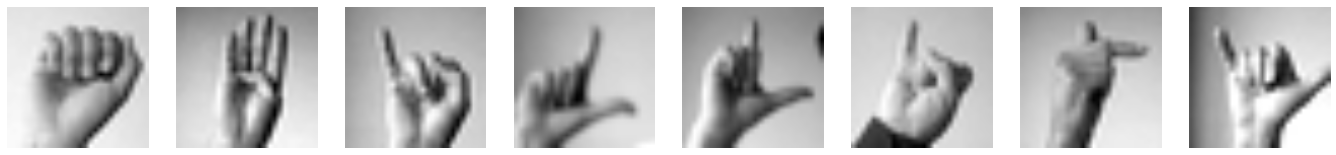


Distorted Sequence


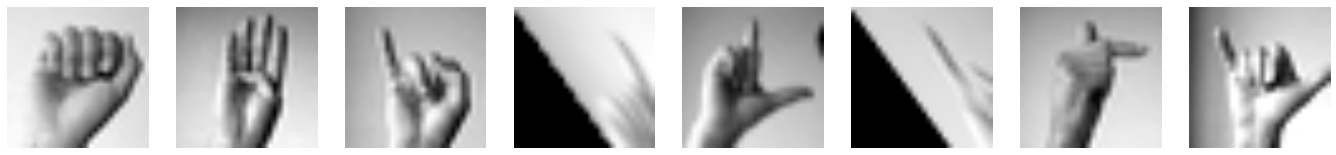


CNN output	:  abipltty

LSTM over CNN output	:  abilltty

Seq2Seq over CNN output	:  abiltyty


CLSTM output:  abillity

Seq2Seq over CLSTM output:  abillity


In [0]:
dat, temp_label = distortion_test(986, 2, testWordstestImages, data)

run(dat, temp_label)

Original Word:  abillity


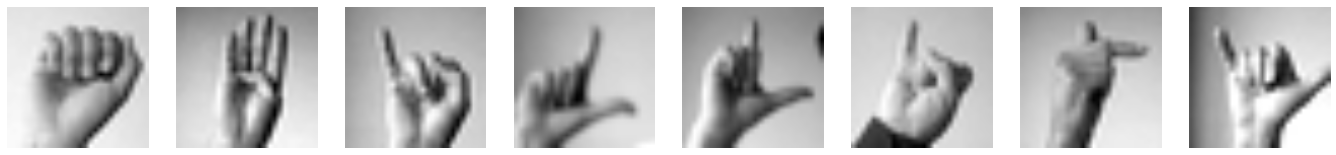


Distorted Sequence


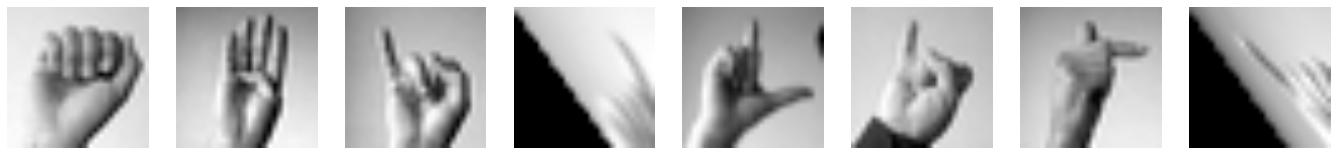


CNN output	:  abiplity

LSTM over CNN output	:  abillity

Seq2Seq over CNN output	:  abillity


CLSTM output:  abillity

Seq2Seq over CLSTM output:  abillity


In [0]:
dat, temp_label = distortion_test(986, 2, testWordstestImages, data)

run(dat, temp_label)

Original Word:  abillity


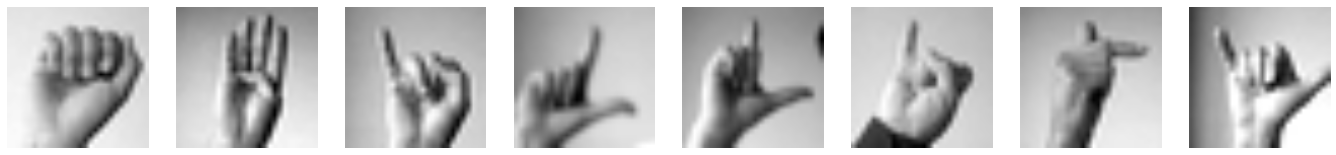


Distorted Sequence


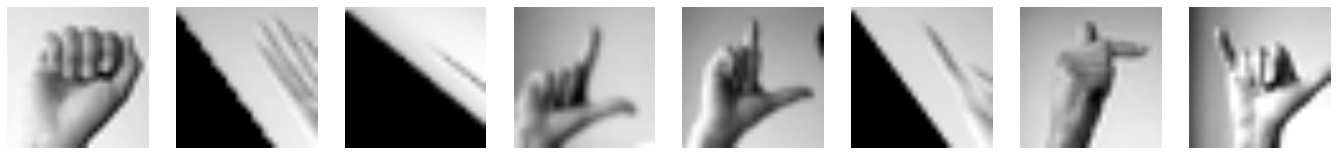


CNN output	:  ahplltty

LSTM over CNN output	:  ahplltty

Seq2Seq over CNN output	:  abiltyty


CLSTM output:  acpllity

Seq2Seq over CLSTM output:  acomplis


In [0]:
dat, temp_label = distortion_test(986, 4, testWordstestImages, data)

run(dat, temp_label)

Original Word:  abillity


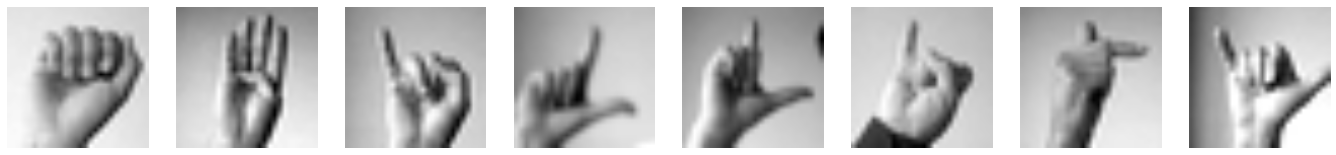


Distorted Sequence


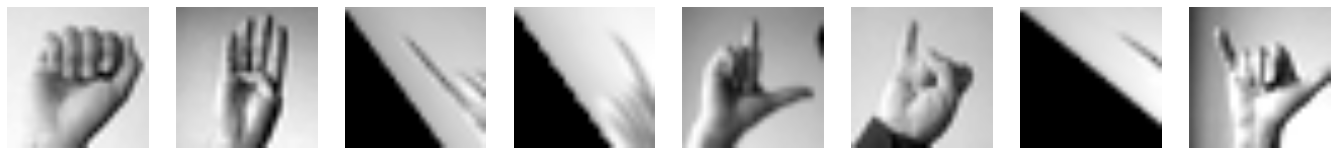


CNN output	:  abpplipy

LSTM over CNN output	:  ampplity

Seq2Seq over CNN output	:  abilityi


CLSTM output:  abpiligy

Seq2Seq over CLSTM output:  abillity


In [0]:
dat, temp_label = distortion_test(986, 4, testWordstestImages, data)

run(dat, temp_label)

## Conclusions
<div style="text-align: justify"> This project presents a combination of CNN, LSTM, and sequence-to-sequence model to solve word prediction problem from a sequence of images. There are 5 models examined, basic CNN, CNN + LSTM, CNN + sequence-to-sequence model, CLSTM, and CLSTM + sequence-to-sequence model. The hand gesture images dataset is exploited to train the basic CNN. A code is created to generate the sequence of images dataset which represents a unique word. In order to train the LSTM, frequent misspelled word is crawled from wikipedia. A further point, some mutation of misspelled word also generated to increase the number of data. Our numerical study shows that CLSTM + sequence-to-sequence model delivers the most encouraging numerical result from other four benchmarked algorithms. It demonstrate the advantage of sequence-to-sequence model which is capable of considering the whole word while delivering the result.<div>

## Reproduce the result

### CNN

In [0]:
% run CNN_base.ipynb #cuda

### Unidirectional LSTM

In [0]:
% run LSTM_Unidirectional.ipynb #cuda

### Bidirectional LSTM without dropout

In [0]:
% run LSTM_Bidirectional.ipynb #cuda

### Bidirectional LSTM with dropout

In [0]:
% run LSTM_Bidirectional_drop_out.ipynb #cuda

### Sequence-to-sequence Model

In [0]:
% run Seq_2_Seq_model.ipynb #cuda

### CLSTM

In [0]:
% run ConvLSTM.ipynb #cuda